In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import scipy.constants as const


df = pd.read_csv(r"exoplanet_catalogue.csv")
print(len(df))

# Replace infinite values with NaN
df = df.replace([np.inf, -np.inf], np.nan)
# column_list = df.columns.tolist()

# for col in df.columns:
#     data_type = df[col].dtype
#     print(f"Column '{col}': Data Type = {data_type}")


7408


In [17]:
df_mr = df[['mass','radius','mass_error_min']].copy() # df with only mass and radius columns

c_df_mr = df_mr.dropna().copy()
print(len(c_df_mr))

r_df_mr = df_mr.dropna(subset=['radius']).copy() # all rows have radius
print(len(r_df_mr))
m_df_mr = df_mr.dropna(subset=['mass']).copy() # all rows have mass
print(len(m_df_mr))

1874
4964
4448


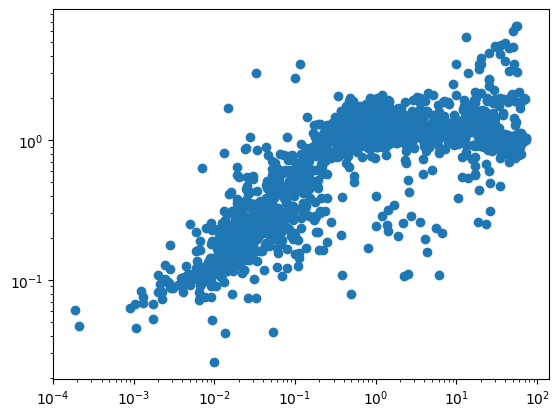

In [18]:
# ploting radius vs mass
y = c_df_mr["radius"]
x = c_df_mr["mass"]

plt.scatter(x,y)
plt.xscale('log')
plt.yscale('log')
plt.show()

c:\Users\arpan\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


 message: NaN result encountered.
 success: False
  status: 3
     fun: nan
       x: [ 5.000e+03  1.000e+03  1.276e+07]
     nit: 0
     jac: [       nan        nan        nan]
    nfev: 4
    njev: 1
[5000.0, 1000.0, 12756200.0]
[5.00000e+03 1.00000e+03 1.27562e+07]


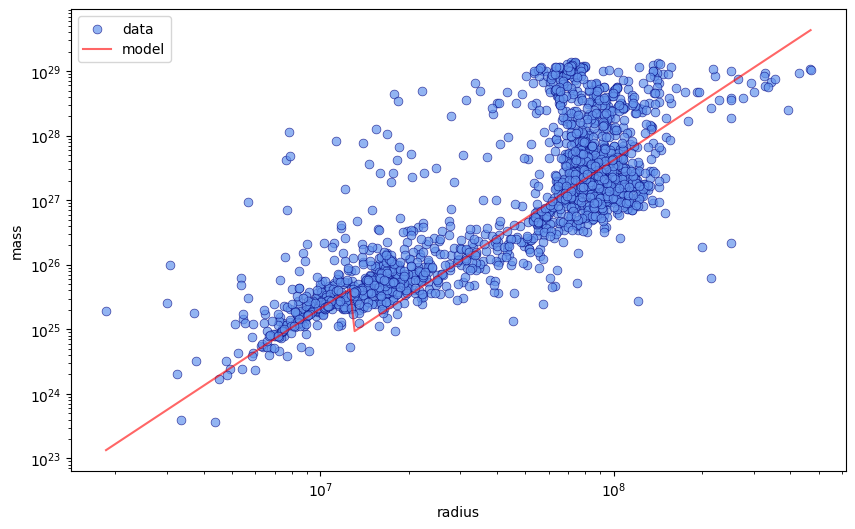

final params
 density of rocky planets = 5.0000 gm/cm^3 
 density of gas planets = 1.0000 gm/cm^3
 threshold radius of rocky planets =  2.0000 Earth radii


In [19]:
# Assuming c_df_mr is your dataframe with mass and radius data
x = np.array(c_df_mr["radius"]) * 7.149e+7 # jupiter radius to metre
y = np.array(c_df_mr["mass"])   * 1.899e+27 # jupiter mass to kg
err = np.array(c_df_mr['mass_error_min']) * 1.899e+27 # jupiter mass to kg

# Create figure with appropriate size
plt.figure(figsize=(10, 6))

# Create scatter plot with better aesthetics
scatter = plt.scatter(x, y, alpha=0.7, s=40, c='cornflowerblue', edgecolor='navy', linewidth=0.5, label = 'data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius')
plt.ylabel('mass')

def simple_mass_model(radius, d_rocky, d_gas, threshold_radius):
    mass = np.array([(4/3 * np.pi  * r ** 3) * d_rocky  if r < threshold_radius else (4/3 * np.pi  * r ** 3) * d_gas for r in radius])
    return mass

def loglikelihood(params):
    N = simple_mass_model(x,params[0],params[1],params[2])
    LL = -np.sum(stats.norm.logpdf(y,loc=N, scale = err))
    return LL

init_d_rocky = 5e3 # 5 gm/cm^3 converted into kg/m^3
init_d_gas = 1e3 # 5 gm/cm^3 converted into kg/m^3
init_threshold_radius = 2 * 6.3781e6 # 2 Earth radius converted into m

initparams = [init_d_rocky,init_d_gas,init_threshold_radius]

results = minimize(loglikelihood, x0 = initparams, method = 'CG', tol = 1e-8)

print(results)
print(initparams)
print(results.x)

estParms = results.x
x_ = np.linspace(min(x),max(x),1000)
y_ =  simple_mass_model(x_,*estParms) 

plt.plot(x_,y_, color = 'r', alpha = 0.6, label = 'model')
plt.legend()
plt.show()

print("final params")
print(f" density of rocky planets = {estParms[0]/1000:.4f} gm/cm^3 \n density of gas planets = {estParms[1]/1000:.4f} gm/cm^3")
print(f" threshold radius of rocky planets = {estParms[2]  / 6.3781e6: .4f} Earth radii")


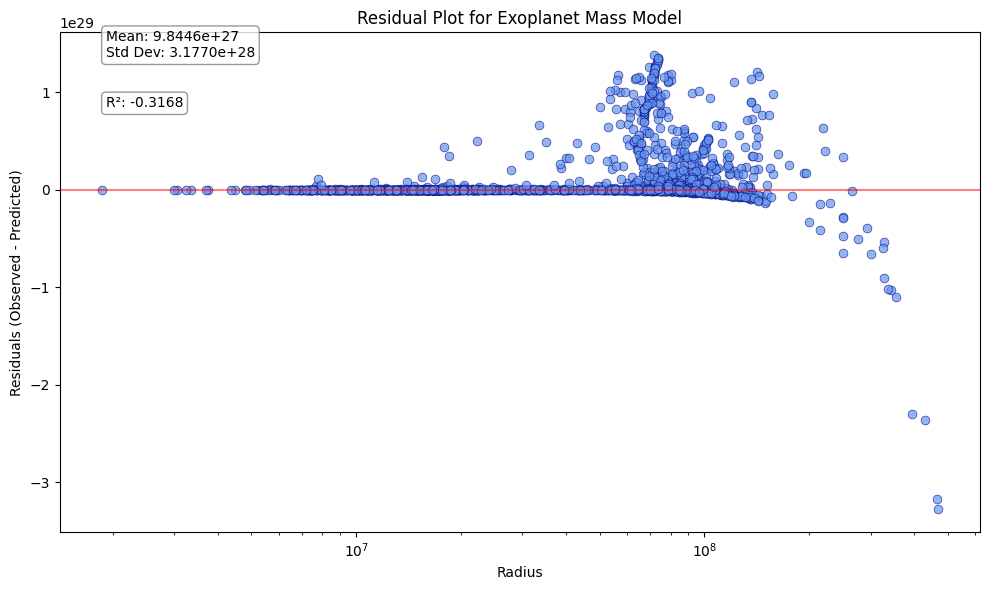

In [20]:
# Calculate the model predictions for the actual data points
y_model = simple_mass_model(x, *estParms)

# Calculate residuals (observed - predicted)
residuals = y - y_model

# Create a new figure for residuals
plt.figure(figsize=(10, 6))

# Plot residuals vs. radius
plt.scatter(x, residuals, alpha=0.7, s=40, c='cornflowerblue', edgecolor='navy', linewidth=0.5)
plt.xscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.5)

# Add labels and title
plt.xlabel('Radius')
plt.ylabel('Residuals (Observed - Predicted)')
plt.title('Residual Plot for Exoplanet Mass Model')

# Add some statistics to the plot
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
plt.annotate(f'Mean: {mean_residual:.4e}\nStd Dev: {std_residual:.4e}', 
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Calculate and display R-squared
ss_tot = np.sum((y - np.mean(y))**2)
ss_res = np.sum(residuals**2)
r_squared = 1 - (ss_res / ss_tot)
plt.annotate(f'R²: {r_squared:.4f}', 
             xy=(0.05, 0.85), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


# Show the plots
plt.tight_layout()
plt.show()

In [21]:
alpha = np.sqrt((1.5+1) * 1 * (1000 ** (1/1.5 + 1)) / (4 * np.pi * const.G))

print(alpha)

print(7.149e+7/alpha)

17264826.188282687
4.140788862880005


100
100
100
100


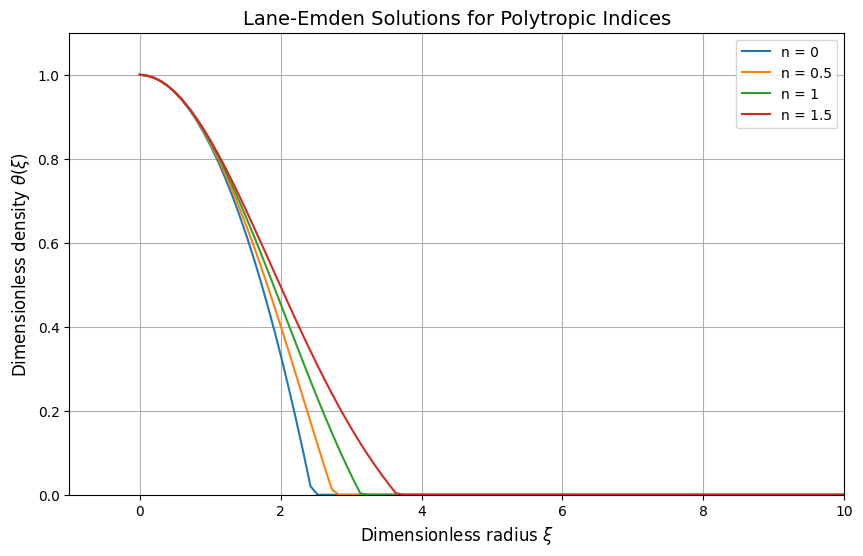

In [41]:
import numba

@numba.jit(nopython=True)
def rk4_lane_emden_numba(n, xi_max=10.0, num_points=100):
    def lane_emden_deriv(xi, theta, phi, n):
        if xi == 0:  # Handle singularity at xi=0
            dtheta = 0
        else:
            dtheta = -phi / xi**2
        if theta < 0:
            theta = 0
        dphi = theta**n * xi**2
        return dtheta, dphi
    # Starting conditions
    xi = np.linspace(1e-8, xi_max, num_points)
    h = xi[1] - xi[0]
    
    # Arrays to store solutions
    theta = np.zeros_like(xi)
    phi = np.zeros_like(xi)
    
    # Initial conditions
    theta[0] = 1.0
    phi[0] = 0.0
    
    # RK4 integration
    for i in range(1, len(xi)):
        k1_theta, k1_phi = lane_emden_deriv(xi[i-1], theta[i-1], phi[i-1], n)
        
        k2_theta, k2_phi = lane_emden_deriv(xi[i-1] + h/2, theta[i-1] + h/2 * k1_theta, phi[i-1] + h/2 * k1_phi, n)
        
        k3_theta, k3_phi = lane_emden_deriv(xi[i-1] + h/2, theta[i-1] + h/2 * k2_theta, phi[i-1] + h/2 * k2_phi, n)
        
        k4_theta, k4_phi = lane_emden_deriv(xi[i-1] + h, theta[i-1] + h * k3_theta, phi[i-1] + h * k3_phi, n)
        
        theta[i] = theta[i-1] + h/6 * (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta)
        phi[i] = phi[i-1] + h/6 * (k1_phi + 2*k2_phi + 2*k3_phi + k4_phi)
        
        if theta[i] <= 0:
            theta[i:] = 0  # Fill rest with zeros
            break
    
    return xi, theta

def rk4_lane_emden(n, xi_max=10.0, num_points=100):
    # Starting conditions
    xi = np.linspace(1e-8, xi_max, num_points)  # Avoid xi=0 singularity
    # print('here',len(xi))
    h = xi[1] - xi[0]  # Step size
    
    # Arrays to store solutions
    theta = np.zeros_like(xi)
    phi = np.zeros_like(xi)
    
    # Initial conditions
    theta[0] = 1.0
    phi[0] = 0.0
    
    # RK4 integration
    for i in range(1, len(xi)):
        
        k1_theta, k1_phi = lane_emden_deriv(xi[i-1], theta[i-1], phi[i-1], n)
        
        k2_theta, k2_phi = lane_emden_deriv(xi[i-1] + h/2, theta[i-1] + h/2 * k1_theta, phi[i-1] + h/2 * k1_phi, n)
        
        k3_theta, k3_phi = lane_emden_deriv(xi[i-1] + h/2, theta[i-1] + h/2 * k2_theta, phi[i-1] + h/2 * k2_phi, n)
        
        k4_theta, k4_phi = lane_emden_deriv(xi[i-1] + h, theta[i-1] + h * k3_theta, phi[i-1] + h * k3_phi, n)
        
        theta[i] = theta[i-1] + h/6 * (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta)
        phi[i] = phi[i-1] + h/6 * (k1_phi + 2*k2_phi + 2*k3_phi + k4_phi)
        
        # Check if theta becomes negative (reached the surface)
        if theta[i] <= 0:
            break
    
    return xi, theta

def solve_lane_emden(n, xi_max=10.0):
    return rk4_lane_emden_numba(n, xi_max)


# Plot solutions for n = 0, 1, 2, 3, 4, 5
n_values = [0,0.5,1,1.5]
plt.figure(figsize=(10, 6))

for n in n_values:
    xi, theta = solve_lane_emden(n)
    plt.plot(xi, theta, label=f'n = {n}')
    print(len(xi))

plt.xlabel(r'Dimensionless radius $\xi$', fontsize=12)
plt.ylabel(r'Dimensionless density $\theta(\xi)$', fontsize=12)
plt.title('Lane-Emden Solutions for Polytropic Indices', fontsize=14)
plt.legend()
plt.grid(True)
plt.xlim(-1,10)
plt.ylim(0,1.1)

plt.show()

Testing parameters: [1.2756e+07 5.0000e+03 1.0000e+03 1.0000e+00]
Radius 0: r=8.236e+07, rocky_weight=0.000, rocky_mass=1.170e+28
  density_term=1.000e+05, constant_term=2.981e+09, alpha=1.726e+07
  r/alpha=4.770e+00
  xi_max=4.770e+00
  Lane-Emden solution: 100 points, theta_0=1.000, theta_end=0.000
  integral=4.185e+00, gas_mass=2.707e+26
  total_mass=2.707e+26 
  real mass = 1.091e+28
Radius 1: r=1.215e+08, rocky_weight=0.000, rocky_mass=3.760e+28
  density_term=1.000e+05, constant_term=2.981e+09, alpha=1.726e+07
  r/alpha=7.039e+00
  xi_max=7.039e+00
  Lane-Emden solution: 100 points, theta_0=1.000, theta_end=0.000
  integral=4.186e+00, gas_mass=2.707e+26
  total_mass=2.707e+26 
  real mass = 2.659e+28
Radius 2: r=2.502e+08, rocky_weight=0.000, rocky_mass=3.281e+29
  density_term=1.000e+05, constant_term=2.981e+09, alpha=1.726e+07
  r/alpha=1.449e+01
  xi_max=1.449e+01
  Lane-Emden solution: 100 points, theta_0=1.000, theta_end=0.000
  integral=4.181e+00, gas_mass=2.704e+26
  total

C:\Users\arpan\AppData\Local\Temp\ipykernel_41592\3576352641.py:26: RuntimeWarning: overflow encountered in exp
  rocky_weight = 1.0 / (1.0 + np.exp((r - threshold_radius) / (s_width * threshold_radius)))
C:\Users\arpan\AppData\Local\Temp\ipykernel_41592\3576352641.py:101: RuntimeWarning: divide by zero encountered in divide
  LL = np.sum(residuals**2 / (2 * err**2))
c:\Users\arpan\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Log-likelihood: inf
Testing parameters: [1.2756e+07 5.0000e+03 1.0000e+03 1.0000e+00]
Radius 0: r=8.236e+07, rocky_weight=0.000, rocky_mass=1.170e+28
  density_term=1.000e+05, constant_term=2.981e+09, alpha=1.726e+07
  r/alpha=4.770e+00
  xi_max=4.770e+00
  Lane-Emden solution: 100 points, theta_0=1.000, theta_end=0.000
  integral=4.185e+00, gas_mass=2.707e+26
  total_mass=2.707e+26 
  real mass = 1.091e+28
Radius 1: r=1.215e+08, rocky_weight=0.000, rocky_mass=3.760e+28
  density_term=1.000e+05, constant_term=2.981e+09, alpha=1.726e+07
  r/alpha=7.039e+00
  xi_max=7.039e+00
  Lane-Emden solution: 100 points, theta_0=1.000, theta_end=0.000
  integral=4.186e+00, gas_mass=2.707e+26
  total_mass=2.707e+26 
  real mass = 2.659e+28
Radius 2: r=2.502e+08, rocky_weight=0.000, rocky_mass=3.281e+29
  density_term=1.000e+05, constant_term=2.981e+09, alpha=1.726e+07
  r/alpha=1.449e+01
  xi_max=1.449e+01
  Lane-Emden solution: 100 points, theta_0=1.000, theta_end=0.000
  integral=4.181e+00, gas_ma

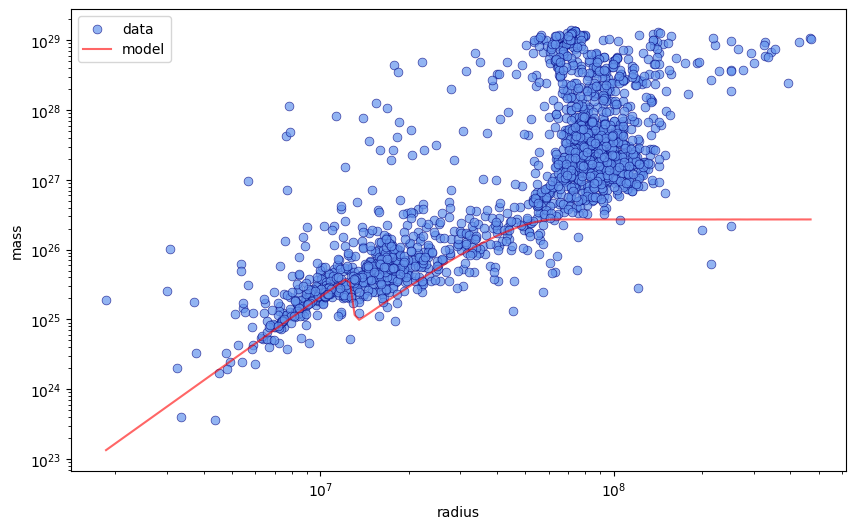

final params
 density of rocky planets = 5.0000 gm/cm^3 
 density of gas planets = 1.0000 gm/cm^3
 threshold radius of rocky planets =  2.0000 Earth radii


In [40]:
from scipy.integrate import trapezoid

# Assuming c_df_mr is your dataframe with mass and radius data
x = np.array(c_df_mr["radius"])           * 7.149e+7 # converting to m
y = np.array(c_df_mr["mass"])             * 1.899e+27 # converting to kg
err = np.array(c_df_mr['mass_error_min']) * 1.899e+27 # converting to kg

# Create figure with appropriate size
plt.figure(figsize=(10, 6))

# Create scatter plot with better aesthetics
scatter = plt.scatter(x, y, alpha=0.7, s=40, c='cornflowerblue', edgecolor='navy', linewidth=0.5, label = 'data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius')
plt.ylabel('mass')



# Add debug information
def LE_mass_model(radius, threshold_radius, d_rocky, dc_gas, K_gas, n_gas=1.5, s_width=0.01):
    mass = []
    for i, r in enumerate(radius):
        try:
            # Calculate rocky mass (this should always work)
            rocky_weight = 1.0 / (1.0 + np.exp((r - threshold_radius) / (s_width * threshold_radius)))
            rocky_mass = (4/3 * np.pi * r**3) * d_rocky
            
            # Debug print for first few points
            if i < 3:
                print(f"Radius {i}: r={r:.3e}, rocky_weight={rocky_weight:.3f}, rocky_mass={rocky_mass:.3e}")
            
            # Calculate alpha with safety checks
            try:
                # Print intermediate values for troubleshooting
                density_term = dc_gas ** (1/n_gas + 1)
                constant_term = (n_gas+1) * K_gas / (4 * np.pi * const.G)
                alpha = np.sqrt(constant_term * density_term)
                
                if i < 3:
                    print(f"  density_term={density_term:.3e}, constant_term={constant_term:.3e}, alpha={alpha:.3e}")
            except Exception as e:
                print(f"  Error calculating alpha: {str(e)}")
                return np.ones_like(radius) * np.inf
            
            # Solve Lane-Emden with safe xi_max
            if i < 3:
                print(f"  r/alpha={r/alpha:.3e}")
            xi_max = min(max(r/alpha, 1e-4), 100)
            if i < 3:
                print(f"  xi_max={xi_max:.3e}")


            try:
                xi, theta = solve_lane_emden(n_gas, xi_max=xi_max)
                if i < 3:
                    print(f"  Lane-Emden solution: {len(xi)} points, theta_0={theta[0]:.3f}, theta_end={theta[-1]:.3f}")
            except Exception as e:
                print(f"  Error in Lane-Emden solver: {str(e)}")
                return np.ones_like(radius) * np.inf
                
            # Calculate integral and gas mass
            try:
                integrand = xi**2 * theta
                integral = trapezoid(integrand, xi)
                gas_mass = 4 * np.pi * dc_gas * alpha**3 * integral
                
                if i < 3:
                    print(f"  integral={integral:.3e}, gas_mass={gas_mass:.3e}")
            except Exception as e:
                print(f"  Error in integration: {str(e)}")
                return np.ones_like(radius) * np.inf
            
            # Calculate total mass
            total_mass = rocky_weight * rocky_mass + (1 - rocky_weight) * gas_mass
            if i < 3:
                print(f"  total_mass={total_mass:.3e} \n  real mass = {y[i]:.3e}")
                
            mass.append(total_mass)
            
        except Exception as e:
            print(f"Error at radius {r}: {str(e)}")
            return np.ones_like(radius) * np.inf
    
    return np.array(mass)

def loglikelihood(params):
    try:
        # Print parameters being tested
        print(f"Testing parameters: {params}")
        
        N = LE_mass_model(x, *params)
        
        # Check for any issues in model output
        if np.any(np.isnan(N)) or np.any(np.isinf(N)):
            print("Warning: Model returned NaN or Inf values")
            return 1e10  # Return a large positive value
            
        # Calculate log-likelihood
        residuals = y - N
        LL = np.sum(residuals**2 / (2 * err**2))
        
        print(f"Log-likelihood: {LL}")
        return LL
        
    except Exception as e:
        print(f"Error in loglikelihood: {str(e)}")
        return 1e10  # Return a large positive value

init_d_rocky = 5000 # 5 gm/cm^3 converted kg/m^3
init_d_gas =   1000 # 1 gm/cm^3 converted kg/m^3
init_threshold_radius = 2 * 6.378e+6 # 2 Earth radius converted into m

initparams = [init_threshold_radius,init_d_rocky,init_d_gas, 1]

# Define bounds to ensure densities can't drop below 0
# More reasonable bounds
bounds = [
    (1e6, 1e8),      # threshold_radius: ~1-100 Earth radii
    (1000, 20000),   # d_rocky: 1-20 g/cm³
    (100, 5000),     # dc_gas: 0.1-5 g/cm³
    (1, 1e15)        # K_gas: reasonable range
]

results = minimize(
    loglikelihood, 
    x0=initparams, 
    method='L-BFGS-B',  # Method that supports bounds
    # method='CG', 
    bounds=bounds,
    tol=1e-8
)

print(results)
print(initparams)
print(results.x)

estParms = results.x
x_ = np.linspace(min(x),max(x),1000)
y_ =  LE_mass_model(x_,*estParms) 

plt.plot(x_,y_, color = 'r', alpha = 0.6, label = 'model')
plt.legend()
plt.show()

print("final params")
print(f" density of rocky planets = {estParms[1]/1000:.4f} gm/cm^3 \n density of gas planets = {estParms[2]/1000:.4f} gm/cm^3")
print(f" threshold radius of rocky planets = {estParms[0] / 6.378e+6 : .4f} Earth radii")


In [24]:
# Print summary of your data
print(f"Data summary:")
print(f"Radius range: {min(x):.3e} to {max(x):.3e} m")
print(f"Mass range: {min(y):.3e} to {max(y):.3e} kg")
print(f"Error range: {min(err):.3e} to {max(err):.3e}")

Data summary:
Radius range: 1.859e+06 to 4.690e+08 m
Mass range: 3.608e+23 to 1.394e+29 kg
Error range: 0.000e+00 to 3.988e+29


C:\Users\arpan\AppData\Local\Temp\ipykernel_41592\1349057098.py:25: RuntimeWarning: overflow encountered in exp
  rocky_weight = 1.0 / (1.0 + np.exp((r - threshold_radius) / (s_width * threshold_radius)))


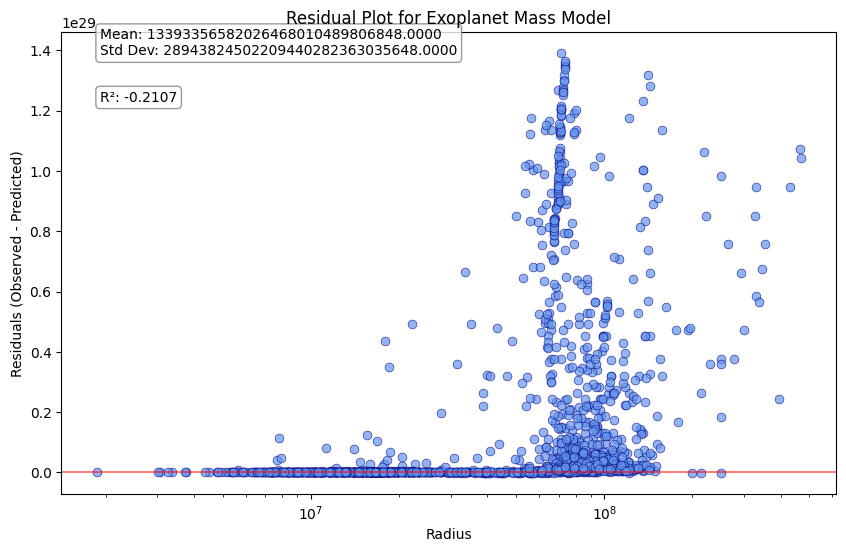

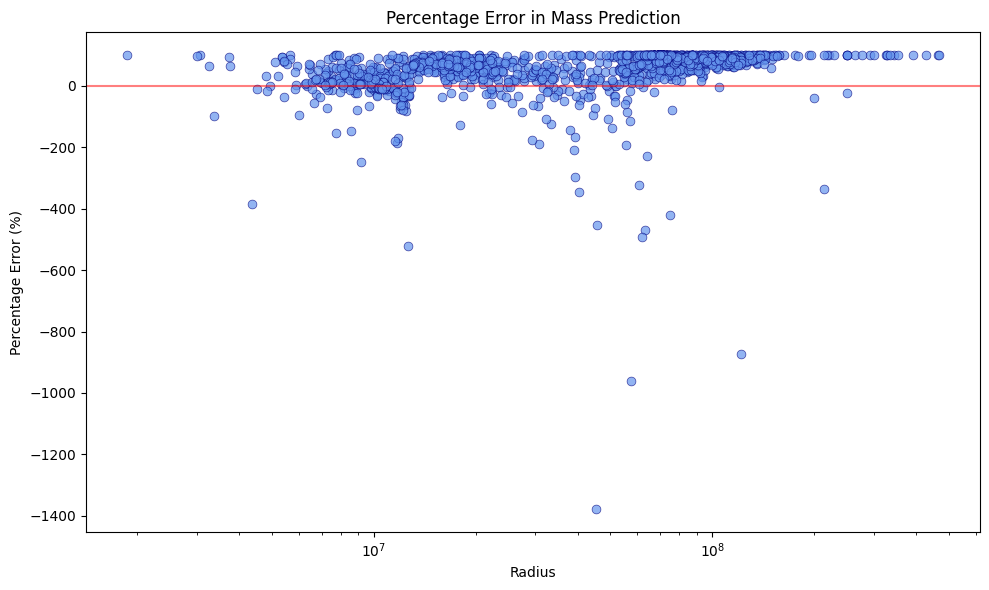

In [25]:
# Calculate the model predictions for the actual data points
y_model = LE_mass_model(x, *estParms)

# Calculate residuals (observed - predicted)
residuals = y - y_model

# Create a new figure for residuals
plt.figure(figsize=(10, 6))

# Plot residuals vs. radius
plt.scatter(x, residuals, alpha=0.7, s=40, c='cornflowerblue', edgecolor='navy', linewidth=0.5)
plt.xscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.5)

# Add labels and title
plt.xlabel('Radius')
plt.ylabel('Residuals (Observed - Predicted)')
plt.title('Residual Plot for Exoplanet Mass Model')

# Add some statistics to the plot
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
plt.annotate(f'Mean: {mean_residual:.4f}\nStd Dev: {std_residual:.4f}', 
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Calculate and display R-squared
ss_tot = np.sum((y - np.mean(y))**2)
ss_res = np.sum(residuals**2)
r_squared = 1 - (ss_res / ss_tot)
plt.annotate(f'R²: {r_squared:.4f}', 
             xy=(0.05, 0.85), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add a percentage error plot
plt.figure(figsize=(10, 6))
percent_error = (residuals / y) * 100
plt.scatter(x, percent_error, alpha=0.7, s=40, c='cornflowerblue', edgecolor='navy', linewidth=0.5)
plt.xscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.5)
plt.xlabel('Radius')
plt.ylabel('Percentage Error (%)')
plt.title('Percentage Error in Mass Prediction')

# Show the plots
plt.tight_layout()
plt.show()

C:\Users\arpan\AppData\Local\Temp\ipykernel_41592\1134129304.py:26: RuntimeWarning: overflow encountered in scalar divide
  alpha = np.sqrt((n_gas+1) * K_gas * (dc_gas ** (1/n_gas + 1)) / (4 * np.pi * const.G))
C:\Users\arpan\AppData\Local\Temp\ipykernel_41592\1134129304.py:31: RuntimeWarning: overflow encountered in scalar power
  gas_mass = 4 * np.pi * dc_gas * alpha**3 * integral


differential_evolution step 1: f(x)= inf
differential_evolution step 2: f(x)= inf
differential_evolution step 3: f(x)= inf
differential_evolution step 4: f(x)= inf
differential_evolution step 5: f(x)= inf
differential_evolution step 6: f(x)= inf
differential_evolution step 7: f(x)= inf
differential_evolution step 8: f(x)= inf
differential_evolution step 9: f(x)= inf
differential_evolution step 10: f(x)= inf
Polishing solution with 'L-BFGS-B'
             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: inf
                   x: [ 4.689e+99  9.765e+99  5.115e+99  7.319e+99
                        3.888e+99  7.505e+99]
                 nit: 10
                nfev: 2667
          population: [[ 4.689e+99  9.765e+99 ...  3.888e+99  7.505e+99]
                       [ 4.375e+98  8.000e+99 ...  2.529e+99  3.079e+99]
                       ...
                       [ 3.681e+99  1.801e+99 ...  5.225e+99  9.849e+99]
                   

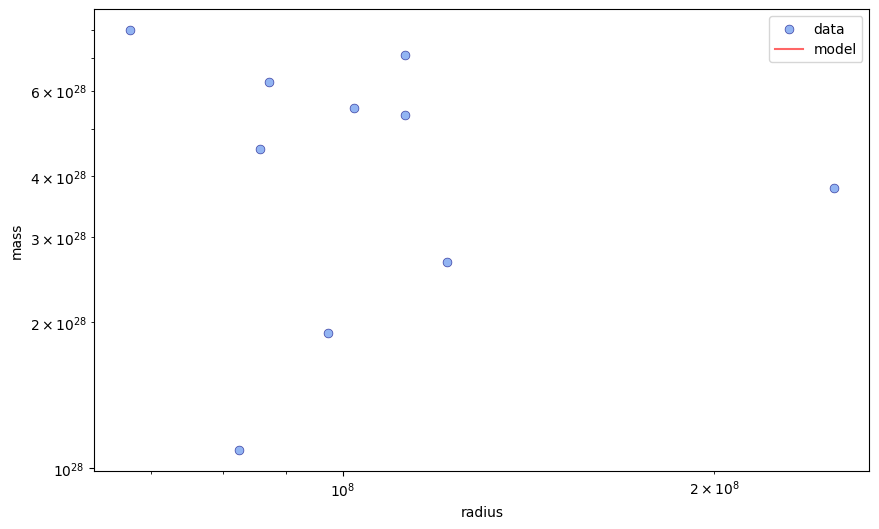

final params
 density of rocky planets = 9765249827401050832575716276994754916348220618445919468812660397526581139848411108391842108932096.0000 gm/cm^3 
 density of gas planets = 5114590036555410010057724796432635809989162360972095755880389077467514636094451716211488298369024.0000 gm/cm^3
 threshold radius of rocky planets =  735122823505834364799638190463249533416550980310095269952843805571960665771260970670101626880.0000 Earth radii


In [26]:
from scipy.integrate import trapezoid

# Assuming c_df_mr is your dataframe with mass and radius data
x = np.array(c_df_mr["radius"])          [:10] * 7.149e+7 # converting to m
y = np.array(c_df_mr["mass"])            [:10] * 1.899e+27 # converting to kg
err = np.array(c_df_mr['mass_error_min'])[:10] * 7.149e+7 # converting to m

# Create figure with appropriate size
plt.figure(figsize=(10, 6))

# Create scatter plot with better aesthetics
scatter = plt.scatter(x, y, alpha=0.7, s=40, c='cornflowerblue', edgecolor='navy', linewidth=0.5, label = 'data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius')
plt.ylabel('mass')

def LE_mass_model(radius, threshold_radius, d_rocky, dc_gas,K_gas, n_gas, s_width):
    mass = []
    for r in radius:
        rocky_weight = 1.0 / (1.0 + np.exp((r - threshold_radius) / (s_width * threshold_radius)))

        rocky_mass = (4/3 * np.pi * r**3) * d_rocky
        
        # solving Lane-Emdem equation
        alpha = np.sqrt((n_gas+1) * K_gas * (dc_gas ** (1/n_gas + 1)) / (4 * np.pi * const.G))
        xi, theta = solve_lane_emden(n_gas, xi_max = r/alpha)
        integrand = xi**2 * theta
        integral = trapezoid(integrand, xi)
        
        gas_mass = 4 * np.pi * dc_gas * alpha**3 * integral

        mass.append(rocky_weight * rocky_mass + (1 - rocky_weight) * gas_mass)

    return np.array(mass)

# Normalize radius and mass
r_scale = np.median(x)
m_scale = np.median(y)

x_norm = x / r_scale
y_norm = y / m_scale

# Adjust model to use normalized values
def LE_mass_model_norm(radius_norm, threshold_radius_norm, d_rocky, dc_gas, K_gas, n_gas, s_width):
    radius = radius_norm * r_scale
    threshold_radius = threshold_radius_norm * r_scale
    masses = LE_mass_model(radius, threshold_radius, d_rocky, dc_gas, K_gas, n_gas, s_width)
    return masses / m_scale

def loglikelihood(params):
    N = LE_mass_model_norm(x,*params)
    LL = -np.sum(stats.norm.logpdf(y,loc=N, scale = err))
    return LL

init_d_rocky = 5000 # 5 gm/cm^3 converted kg/m^3
init_d_gas =   1000 # 1 gm/cm^3 converted kg/m^3
init_threshold_radius = 2 * 6.378e+6 # 2 Earth radius converted into m

initparams = [init_threshold_radius,init_d_rocky,init_d_gas, 1, 1.5, 0.01]

from scipy.optimize import differential_evolution

bounds = [(0, 1e100), (0, 1e100), (0, 1e100), (0, 1e100),(0, 1e100),(0, 1e100)]

results = differential_evolution(
    loglikelihood,
    bounds=bounds,
    strategy='best1bin',
    maxiter=10,
    popsize=20,
    tol=0.01,
    disp = True
)

print(results)
print(initparams)
print(results.x)

estParms = results.x
x_ = np.linspace(min(x),max(x),1000)
y_ =  LE_mass_model(x_,*estParms) 

plt.plot(x_,y_, color = 'r', alpha = 0.6, label = 'model')
plt.legend()
plt.show()

print("final params")
print(f" density of rocky planets = {estParms[1]/1000:.4f} gm/cm^3 \n density of gas planets = {estParms[2]/1000:.4f} gm/cm^3")
print(f" threshold radius of rocky planets = {estParms[0] / 6.378e+6 : .4f} Earth radii")


In [27]:
def LE_mass_model(radius, threshold_radius, d_rocky, dc_gas,K_gas, n_gas = 1.5, s_width = 0.01):
    mass = []
    for r in radius:
        rocky_weight = 1.0 / (1.0 + np.exp((r - threshold_radius) / (s_width * threshold_radius)))

        rocky_mass = (4/3 * np.pi * r**3) * d_rocky
        
        # solving Lane-Emdem equation
        alpha = np.sqrt((n_gas+1) * K_gas * (dc_gas ** (1/n_gas + 1)) / (4 * np.pi * const.G))
        xi, theta = solve_lane_emden(n_gas, xi_max = r/alpha)
        integrand = xi**2 * theta
        integral = trapezoid(integrand, xi)
        
        gas_mass = 4 * np.pi * dc_gas * alpha**3 * integral

        mass.append(rocky_weight * rocky_mass + (1 - rocky_weight) * gas_mass)

    return np.array(mass)

def loglikelihood(params):
    N = LE_mass_model(x, *params)
    # Faster vectorized implementation:
    LL = -np.sum((y - N)**2 / (2 * err**2)) - 0.5 * len(y) * np.log(2 * np.pi) - np.sum(np.log(err))
    # Or even simpler if you don't need the constant terms:
    # LL = -np.sum((y - N)**2 / (2 * err**2))
    return LL